In [1]:
#MNIST Model

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from timeit import default_timer as timer
from tqdm.auto import tqdm

from pathlib import Path
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch Version : {torch.__version__}\nPyTorchVision Version : {torchvision.__version__}")
print(f"TorchMetrics Version : {torchmetrics.__version__}\nDevice : {device}")

PyTorch Version : 2.4.0
PyTorchVision Version : 0.19.0
TorchMetrics Version : 1.4.2
Device : cuda


In [2]:
#Data
trainData = datasets.EMNIST(
    root = "data",
    split = "digits",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

testData = datasets.EMNIST(
    root = "data",
    split = "digits",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

print(f"Training dataset : {trainData}\n\nTest dataset : {testData}")
classNames = trainData.classes

100%|██████████| 561753746/561753746 [00:32<00:00, 17524870.89it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
Training dataset : Dataset EMNIST
    Number of datapoints: 240000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test dataset : Dataset EMNIST
    Number of datapoints: 40000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
#HyperParameters

batchSize = 32
learningRate = 0.01
randomSeed = 18

In [4]:
trainDataLoader = DataLoader(
    dataset = trainData,
    batch_size = batchSize,
    shuffle = True
)

testDataLoader = DataLoader(
    dataset = testData,
    batch_size = batchSize,
    shuffle = False
)

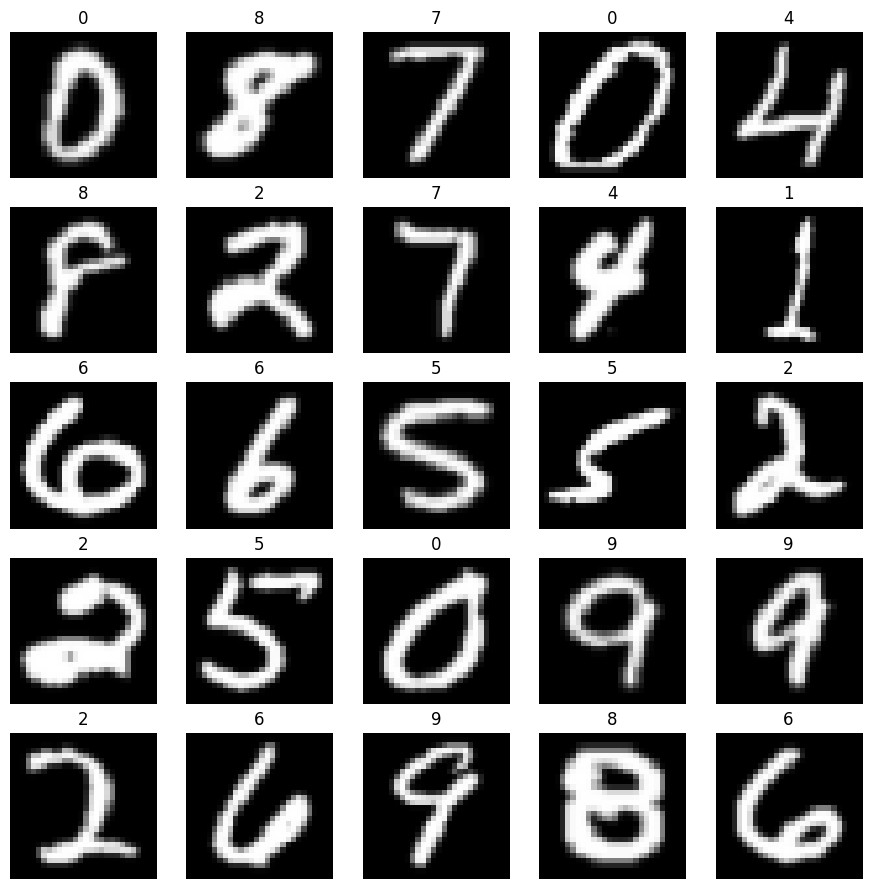

In [5]:
def visualiseFn(set):
    image, label = set
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze().T, cmap = "gray")
    plt.title(classNames[label])
    plt.axis(False)

fig = plt.figure(figsize = (11, 11))
rows, cols = 5, 5

for i in range(1, rows*cols + 1):
    index = torch.randint(0, len(trainData), size = [1]).item()
    visualiseFn(trainData[index])

In [6]:
#Save Model Function
def saveModel(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    modelPath.mkdir(parents = True, exist_ok = True)
    
    modelName = file_name
    modelSavePath = modelPath / modelName
    
    print(f"Saving Model to : {modelSavePath}")
    torch.save(model.state_dict(), modelSavePath)

#Load Model Function
def loadModel(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    
    modelName = file_name
    modelSavePath = modelPath / modelName
    
    model.load_state_dict(torch.load(modelSavePath, weights_only = True))

#Timer Function
def displayTime(start_time,
              end_time,
              device : torch.device = device):
    time = end_time - start_time
    print(f"Total Time : {time} on device {device}.")

In [7]:
#Build a Model
class MNISTModel(nn.Module):
    def __init__(self,
                in_features : int,
                hidden_units : int,
                out_features : int):
        super().__init__()
        self.Layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels = in_features,
                out_channels = hidden_units,
                kernel_size = (3, 3),
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = (3, 3),
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )
        self.Layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = (3, 3),
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = (3, 3),
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2, 2))
        )
        self.Layer3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units * 7 * 7,
                out_features = out_features,
                device = device
            )    
        )

    def forward(self, X):
        Z = self.Layer3(self.Layer2(self.Layer1(X)))
        return Z

In [8]:
torch.manual_seed(randomSeed)

ModelA = MNISTModel(
    in_features = 1,
    hidden_units = 10,
    out_features = len(classNames)
).to(device)

ModelA

MNISTModel(
  (Layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Layer3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [9]:
#Loss, Accuracy and Optimiser
lossFn = nn.CrossEntropyLoss()

accuracyFn = Accuracy(task = "multiclass", num_classes = len(classNames)).to(device)

optimiser = torch.optim.Adam(
    params = ModelA.parameters(),
    lr = learningRate
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma = 0.9)

In [10]:
#Training Loop
def training(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn.Module,
    optimiser : torch.optim.Optimizer,
    accuracy_function,
    device : torch.device = device
):
    train_loss, train_accuracy = 0, 0
    model.to(device)

    for batch, (X, y) in tqdm(enumerate(dataloader),
                              desc = "Batches: ",
                              total = len(dataloader)):

        X, y = X.to(device), y.to(device)
        
        #1. Forward Pass
        trainLogits = model(X)
        trainPreds = torch.softmax(trainLogits, dim = 1).argmax(dim = 1)

        #2. Loss
        loss = lossFn(trainLogits, y)
        train_loss += loss

        accuracy = accuracy_function(trainPreds, y)
        train_accuracy += accuracy
        
        #3. Zero Grad
        optimiser.zero_grad()

        #4. BackPropagation
        loss.backward()

        #5. Gradient Descent
        optimiser.step()

        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(trainDataLoader.dataset)} samples")

    #Calculate Loss and Accuracy
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy * 100:.2f}%")

#Testing Loop
def testing(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn.Module,
    accuracy_function,
    device : torch.device = device,
):
    test_loss, test_accuracy = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for (X, y) in dataloader:
    
            X, y = X.to(device), y.to(device)
            
            #1. Forward Pass
            testLogits = model(X)
            testPreds = torch.softmax(testLogits, dim = 1).argmax(dim = 1)
    
            #2. Loss
            loss = loss_function(testLogits, y)
            test_loss += loss
    
            accuracy = accuracy_function(testPreds, y)
            test_accuracy += accuracy
        #Calculate Loss and Accuracy
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy * 100:.2f}%")

In [11]:
#Training
torch.manual_seed(randomSeed)

startTime = timer()
epochs = 15

for epoch in tqdm(range(epochs),
                  desc = "Epochs: "):
    print(f"Epoch: {epoch + 1}\n---------")
    training(
        model = ModelA,
        dataloader = trainDataLoader,
        loss_function = lossFn,
        optimiser = optimiser,
        accuracy_function = accuracyFn,
        device = device
    )
    testing(
        model = ModelA,
        dataloader = testDataLoader,
        loss_function = lossFn,
        accuracy_function = accuracyFn,
        device = device
    )

endTime = timer()
displayTime(
    start_time = startTime,
    end_time = endTime,
    device = device
)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.10220 | Train accuracy: 97.03%
Test loss: 0.06800 | Test accuracy: 98.01%
Epoch: 2
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07436 | Train accuracy: 97.89%
Test loss: 0.08038 | Test accuracy: 97.75%
Epoch: 3
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07604 | Train accuracy: 97.88%
Test loss: 0.07110 | Test accuracy: 97.93%
Epoch: 4
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07526 | Train accuracy: 97.88%
Test loss: 0.06885 | Test accuracy: 98.11%
Epoch: 5
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07167 | Train accuracy: 98.00%
Test loss: 0.06552 | Test accuracy: 98.31%
Epoch: 6
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07238 | Train accuracy: 98.03%
Test loss: 0.05984 | Test accuracy: 98.15%
Epoch: 7
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.06990 | Train accuracy: 98.07%
Test loss: 0.08618 | Test accuracy: 97.85%
Epoch: 8
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07110 | Train accuracy: 98.06%
Test loss: 0.06865 | Test accuracy: 97.90%
Epoch: 9
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07081 | Train accuracy: 98.06%
Test loss: 0.06202 | Test accuracy: 98.18%
Epoch: 10
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07155 | Train accuracy: 98.03%
Test loss: 0.06514 | Test accuracy: 98.31%
Epoch: 11
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07119 | Train accuracy: 98.03%
Test loss: 0.07501 | Test accuracy: 98.31%
Epoch: 12
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07056 | Train accuracy: 98.06%
Test loss: 0.06536 | Test accuracy: 98.16%
Epoch: 13
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.06859 | Train accuracy: 98.13%
Test loss: 0.05841 | Test accuracy: 98.46%
Epoch: 14
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.07125 | Train accuracy: 98.06%
Test loss: 0.06232 | Test accuracy: 98.39%
Epoch: 15
---------


Batches:   0%|          | 0/7500 [00:00<?, ?it/s]

Looked at 0/240000 samples
Looked at 12800/240000 samples
Looked at 25600/240000 samples
Looked at 38400/240000 samples
Looked at 51200/240000 samples
Looked at 64000/240000 samples
Looked at 76800/240000 samples
Looked at 89600/240000 samples
Looked at 102400/240000 samples
Looked at 115200/240000 samples
Looked at 128000/240000 samples
Looked at 140800/240000 samples
Looked at 153600/240000 samples
Looked at 166400/240000 samples
Looked at 179200/240000 samples
Looked at 192000/240000 samples
Looked at 204800/240000 samples
Looked at 217600/240000 samples
Looked at 230400/240000 samples
Train loss: 0.06989 | Train accuracy: 98.08%
Test loss: 0.07914 | Test accuracy: 97.98%
Total Time : 891.0229113490001 on device cuda.


In [12]:
#Evaluate the Model
def evalModel(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn.Module,
    accuracy_function,
    device : torch.device = device
):
    test_loss, test_accuracy = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for (X, y) in tqdm(dataloader,
                           desc = "Batches: ",
                           total = len(dataloader)):
    
            X, y = X.to(device), y.to(device)
            
            #1. Forward Pass
            testLogits = model(X)
            testPreds = torch.softmax(testLogits, dim = 1).argmax(dim = 1)
    
            #2. Loss
            loss = loss_function(testLogits, y)
            test_loss += loss
    
            accuracy = accuracy_function(testPreds, y)
            test_accuracy += accuracy
        #Calculate Loss and Accuracy
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
        
        return {'model_name' : model.__class__.__name__,
          'model_loss' : test_loss.item(),
          'model_acc' : test_accuracy.item()*100}

In [13]:
ModelAEvals = evalModel(
    model = ModelA,
    dataloader = testDataLoader,
    loss_function = lossFn,
    accuracy_function = accuracyFn,
    device = device
)

ModelA

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

MNISTModel(
  (Layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Layer3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [14]:
#Saving our Model
saveModel(
    folder = "models",
    file_name = "MNIST.pth",
    model = ModelA
)

Saving Model to : models/MNIST.pth


In [15]:
#Plot Predictions
def plotPredictions(
    rows : int,
    cols : int
):
    plt.figure(figsize = (rows * 2.4, cols * 2.4))
    
    for i in range(1, rows * cols + 1):
        #Random Index
        index = torch.randint(0, len(testData), size = [1]).item()

        #Image and Label
        image, label = testData[index]
        
        #Add SubPlot
        plt.subplot(rows, cols, i)
        plt.imshow(image.squeeze().T, cmap = "gray")
        plt.axis(False)

        predictionLabel = classNames[torch.softmax(ModelA(image.unsqueeze(dim = 0).to(device)), dim = 1).argmax(dim = 1)]

        title = f"Pred: {predictionLabel[0]} | Truth: {classNames[label][0]}"

        if predictionLabel == classNames[label]:
            plt.title(title, c = "g")

        else:
            plt.title(title, c = "r")

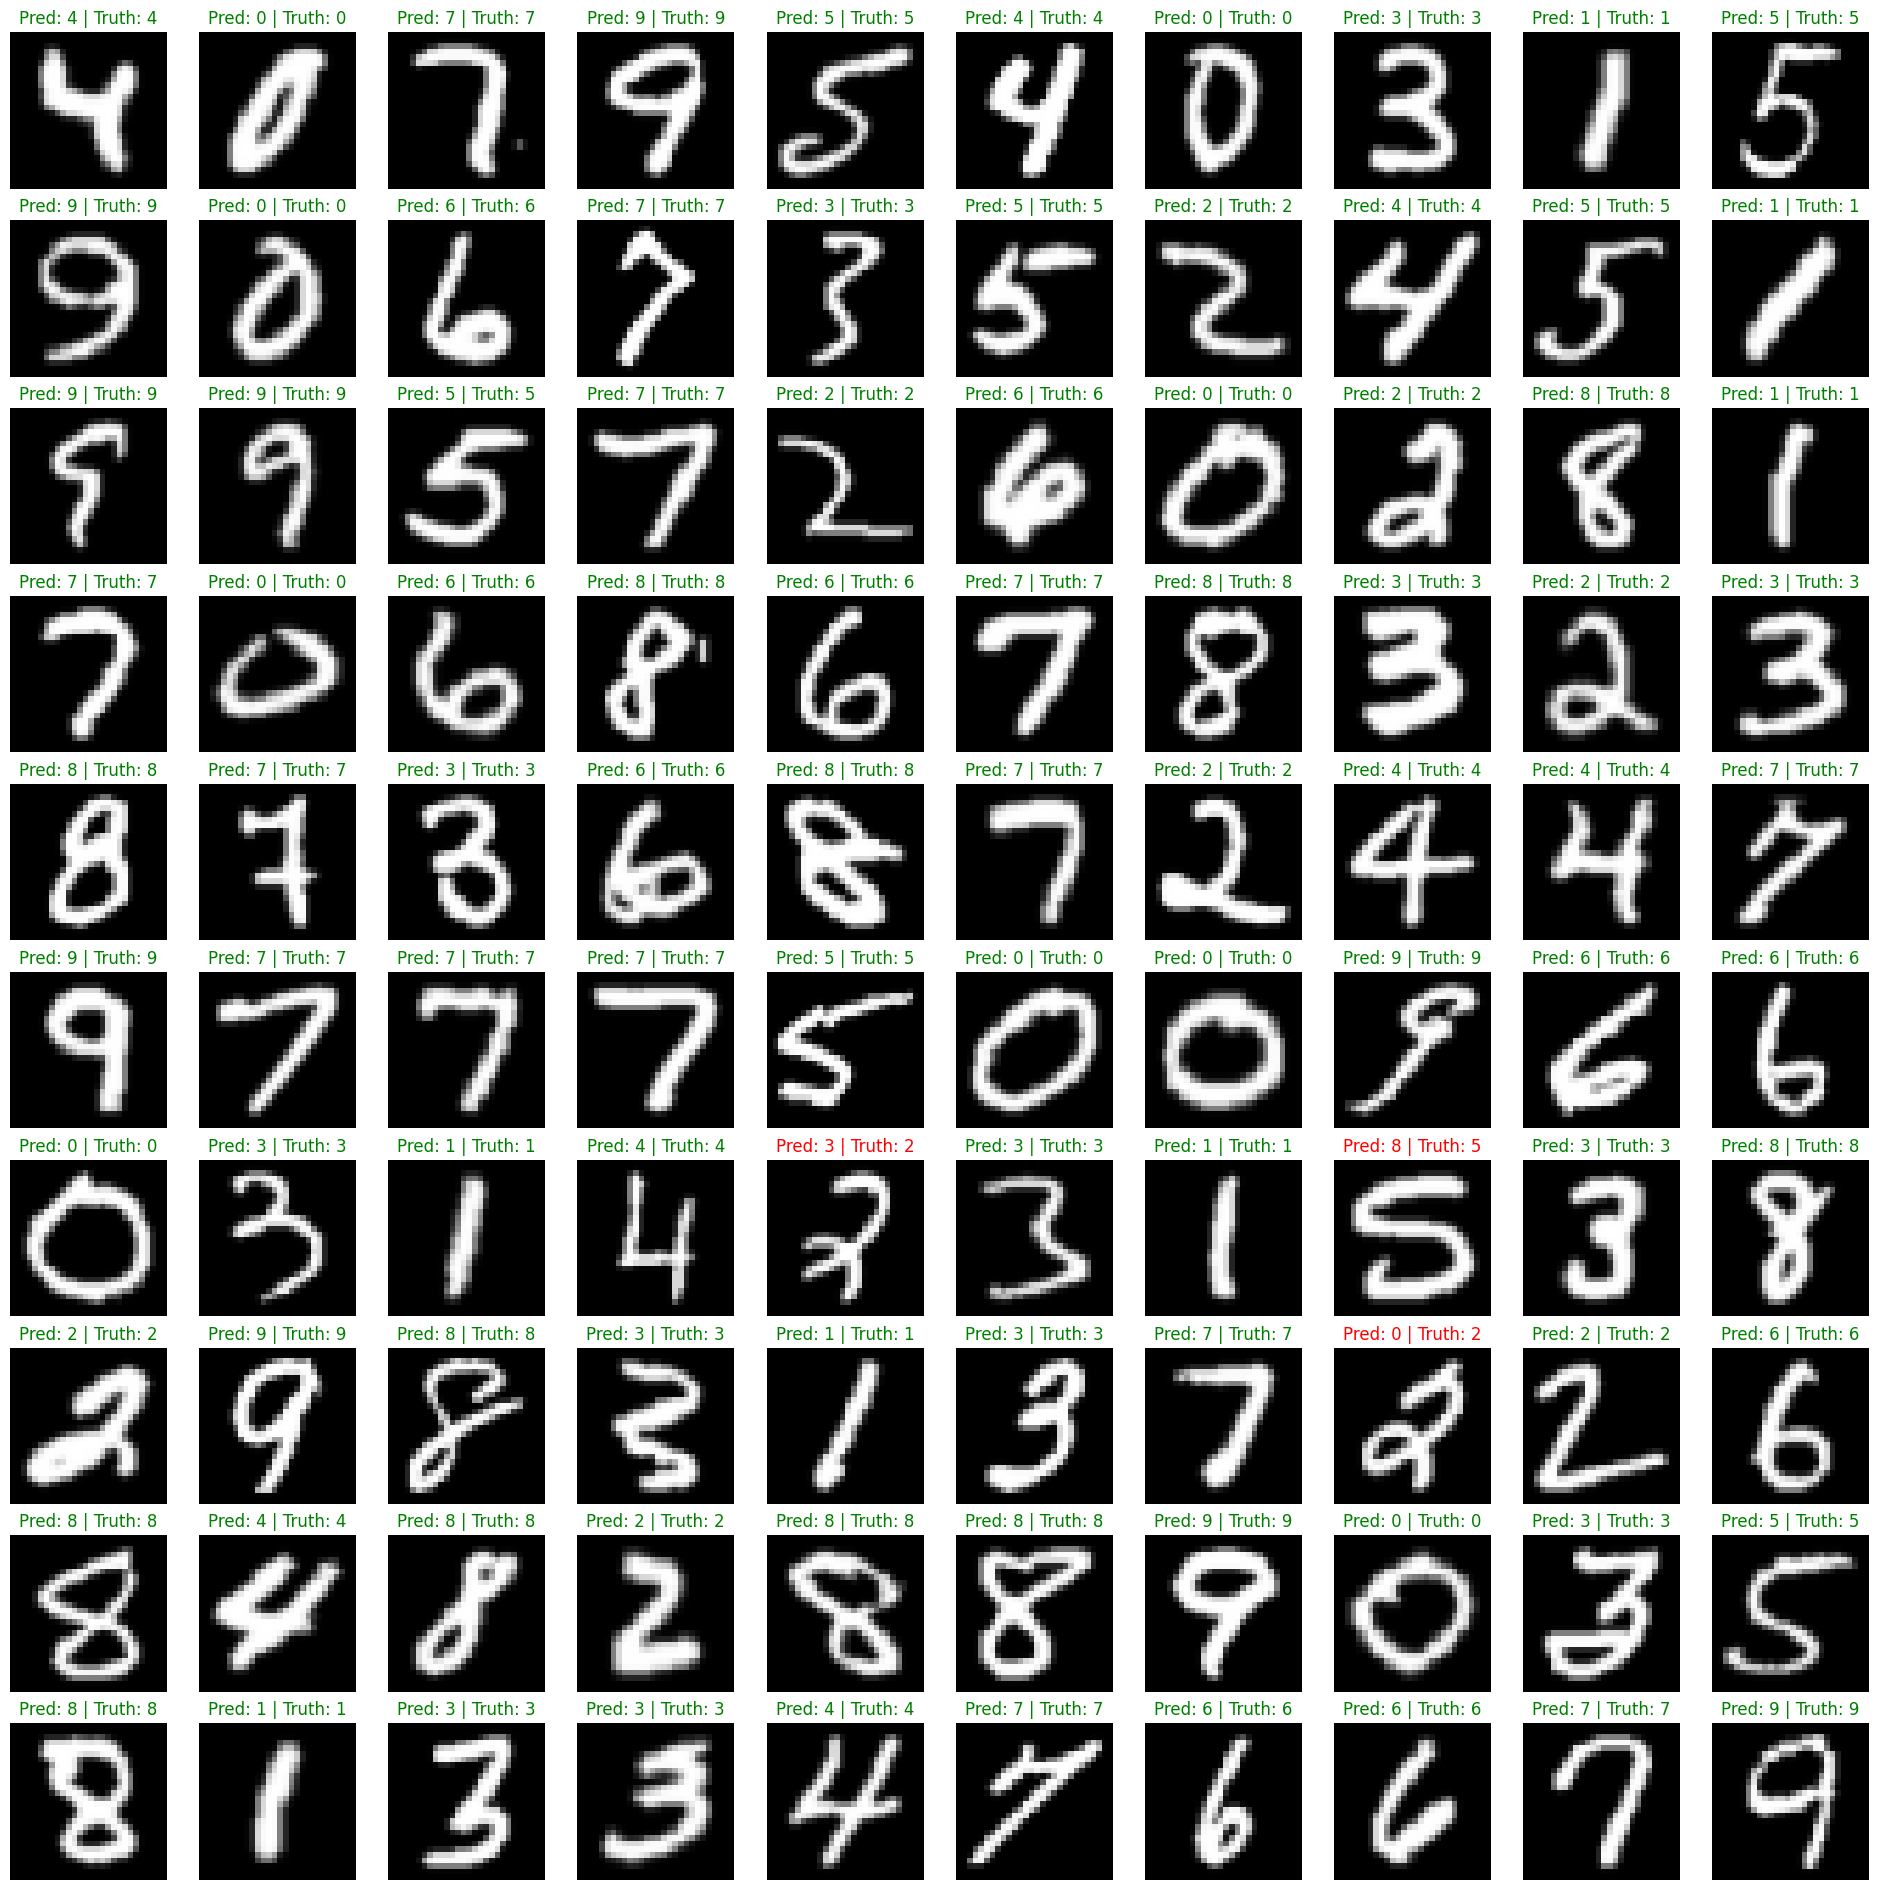

In [16]:
plotPredictions(10, 10)

In [17]:
#Create Predictions List
listPredictions = []
with torch.inference_mode():
    for (X, y) in tqdm(testDataLoader, desc = "Predictions Loading"):

        X, y = X.to(device), y.to(device)
        
        testLogits = ModelA(X)
        testPreds = torch.softmax(testLogits, dim = 1).argmax(dim = 1)
        listPredictions.append(testPreds)

tensorPredictions = torch.cat(listPredictions)

Predictions Loading:   0%|          | 0/1250 [00:00<?, ?it/s]

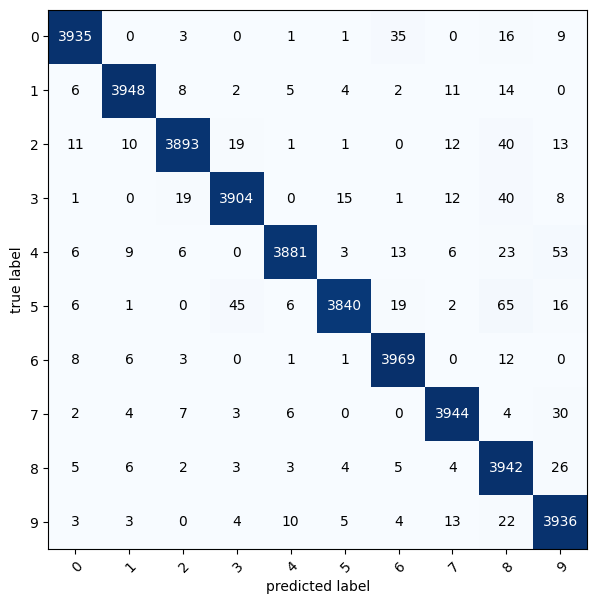

In [18]:
def confusionMatrix(classNames : list,
                   tensorPredictions : torch.Tensor,
                   testData : torchvision.datasets,
                   device : torch.device = device):
    confusionMatrix = ConfusionMatrix(task = "multiclass",
                                      num_classes = len(classNames)).to(device)
    tensorConfusionMatrix = confusionMatrix(tensorPredictions.to(device), testData.targets.to(device))
    
    plot_confusion_matrix(
        conf_mat = tensorConfusionMatrix.numpy(),
        class_names = classNames,
        figsize = (10, 7)
    )

confusionMatrix(classNames = classNames,
               tensorPredictions = tensorPredictions,
               testData = testData,
               device = "cpu")